# Task 7:  Sales Forecasting Description
## *Description:*
1. Dataset (Recommended): [Walmart Sales Forecast Kaggle](https://www.kaggle.com/datasets/aslanahmedov/walmart-sales-forecast).
2. Predict future sales based on historical sales data.
3. Create time-based features (day, month, lag values).
4. Apply regression models to forecast next period's sales.
5. Plot actual vs. predicted values over time.

### Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score

### Data Loading

In [5]:
train = pd.read_csv('/kaggle/input/walmart-sales-forecast/train.csv')
test = pd.read_csv('/kaggle/input/walmart-sales-forecast/test.csv')
feat = pd.read_csv('/kaggle/input/walmart-sales-forecast/features.csv')
stores = pd.read_csv('/kaggle/input/walmart-sales-forecast/stores.csv')

In [6]:
train.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False


In [7]:
test.head(3)

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False


In [8]:
feat.head(3)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False


In [9]:
stores.head(3)

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392


### Drop ```'MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'```

In [10]:
feat.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'],axis =1 , inplace = True )

### Merge dataframes

In [11]:
merged_df = feat.merge(stores, on='Store', how='left')
merged_df.head(3)

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,211.289143,8.106,False,A,151315


In [12]:
train_merged = train.merge(merged_df, on=['Store', 'Date', 'IsHoliday'], how='left')
test_merged = test.merge(merged_df, on=['Store', 'Date', 'IsHoliday'], how='left')

### Convert Categorical Features to Numerical Features

In [13]:
data=train_merged
data['IsHoliday'] = data['IsHoliday'].map({True: 1, False: 0})
data['Type'].value_counts()
data['Type'] = data['Type'].map({'A': 1, 'B': 2,'C' :3})

In [14]:
data.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,0,42.31,2.572,211.096358,8.106,1,151315
1,1,1,2010-02-12,46039.49,1,38.51,2.548,211.242170,8.106,1,151315
2,1,1,2010-02-19,41595.55,0,39.93,2.514,211.289143,8.106,1,151315


### Add features ```Day,Month,Year,lag,rolling_avg```

In [15]:
data['Date']=pd.to_datetime(data['Date'])
data['day']=data.Date.dt.day
data['month']=data.Date.dt.month
data['year']=data.Date.dt.year
data['lag_1'] = data['Weekly_Sales'].shift(1)
data['lag_7'] = data['Weekly_Sales'].shift(7)  # Weekly lag
data.set_index(data['Date'],inplace=True)
data.drop('Date',axis=1 , inplace =True)
data['rolling_avg_7'] = data['Weekly_Sales'].rolling(window=7).mean()

### Check for duplicate values?

In [16]:
data.duplicated().sum()

0

### Check for missing data?

In [17]:
data.isna().sum()

Store            0
Dept             0
Weekly_Sales     0
IsHoliday        0
Temperature      0
Fuel_Price       0
CPI              0
Unemployment     0
Type             0
Size             0
day              0
month            0
year             0
lag_1            1
lag_7            7
rolling_avg_7    6
dtype: int64

In [18]:
data.shape

(421570, 16)

### Drop missing data

In [19]:
data.dropna(axis=0,inplace=True)

In [20]:
data.isna().sum()

Store            0
Dept             0
Weekly_Sales     0
IsHoliday        0
Temperature      0
Fuel_Price       0
CPI              0
Unemployment     0
Type             0
Size             0
day              0
month            0
year             0
lag_1            0
lag_7            0
rolling_avg_7    0
dtype: int64

### seasonal_decompose

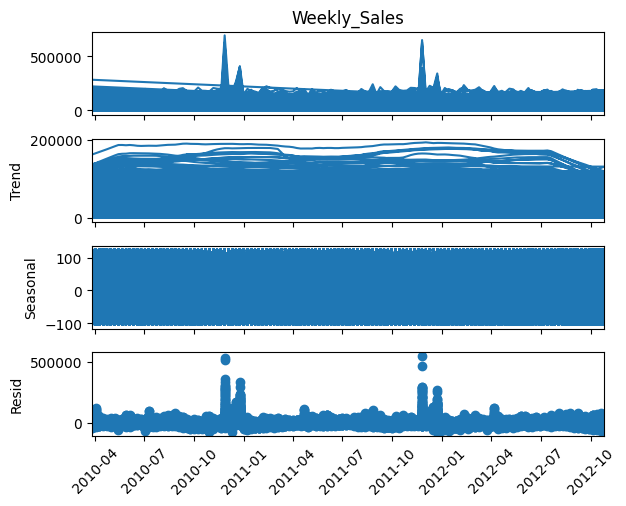

In [21]:
result = seasonal_decompose(data['Weekly_Sales'], model='additive', period=30)
result.plot()
plt.xticks(rotation=45)
plt.show()

### Data Splitting

In [22]:
X = data.drop('Weekly_Sales',axis=1)
y = data['Weekly_Sales']

In [23]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

### Training models on unscaled data

In [24]:
models = {
    'LinearRegression': LinearRegression(),
    'XGBoost': XGBRegressor(),
    'LBGM': lgb.LGBMRegressor()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test,y_pred)
    print(f'{name} - MSE: {mse:.2f} - R2: {r2}')

LinearRegression - MSE: 37871290.84 - R2: 0.9261612905097926
XGBoost - MSE: 11324349.62 - R2: 0.977920600445545
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1998
[LightGBM] [Info] Number of data points in the train set: 295094, number of used features: 15
[LightGBM] [Info] Start training from score 16002.325143
LBGM - MSE: 14459745.28 - R2: 0.9718074323009791


### Hyperparameter tuning

In [25]:
model = lgb.LGBMRegressor()
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [-1, 3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=3, 
                           verbose=1, n_jobs=-1)

In [26]:
grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {-grid_search.best_score_}')

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1998
[LightGBM] [Info] Number of data points in the train set: 196730, number of used features: 15
[LightGBM] [Info] Start training from score 15968.342919
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1998
[LightGBM] [Info] Number of data points in the train set: 196729, number of used features: 15
[LightGBM] [Info] Start training from score 16075.120698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

### Training models with hyperparameter tuning

In [27]:
models = {
    'LinearRegression': LinearRegression(),
    'XGBoost': XGBRegressor(learning_rate= 0.2, max_depth= 7, n_estimators= 200),
    'LBGM': lgb.LGBMRegressor(learning_rate= 0.2, max_depth= -1, n_estimators= 200)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test,y_pred)
    print(f'{name} - MSE: {mse:.2f} - R2: {r2}')

LinearRegression - MSE: 37871290.84 - R2: 0.9261612905097926
XGBoost - MSE: 10539729.03 - R2: 0.9794503970553947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1998
[LightGBM] [Info] Number of data points in the train set: 295094, number of used features: 15
[LightGBM] [Info] Start training from score 16002.325143
LBGM - MSE: 10717770.84 - R2: 0.9791032639763345


### Data Scaling

In [28]:
scaler_X = MinMaxScaler()
X_train_scaled= scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.to_numpy().reshape(-1, 1))

### Training models on data scaled

In [29]:
models = {
    'LinearRegression': LinearRegression(),
    'XGBoost': XGBRegressor(),
    'LBGM': lgb.LGBMRegressor()
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train_scaled)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test_scaled, y_pred)
    r2 = r2_score(y_test_scaled,y_pred)
    print(f'{name} - MSE: {mse:.2f} - R2: {r2}')

LinearRegression - MSE: 0.00 - R2: 0.9261612905097927
XGBoost - MSE: 0.00 - R2: 0.9776741582544302


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1991
[LightGBM] [Info] Number of data points in the train set: 295094, number of used features: 15
[LightGBM] [Info] Start training from score 0.032060
LBGM - MSE: 0.00 - R2: 0.9726894717408894


### Training models with Hyperparameter tuning and data scaled

In [30]:
models = {
    'LinearRegression': LinearRegression(),
    'XGBoost': XGBRegressor(learning_rate= 0.2, max_depth= 7, n_estimators= 200),
    'LBGM': lgb.LGBMRegressor(learning_rate= 0.2, max_depth= -1, n_estimators= 200)
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train_scaled)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test_scaled, y_pred)
    r2 = r2_score(y_test_scaled,y_pred)
    print(f'{name} - MSE: {mse:.2f} - R2: {r2}')

LinearRegression - MSE: 0.00 - R2: 0.9261612905097927
XGBoost - MSE: 0.00 - R2: 0.9791441790061266


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1991
[LightGBM] [Info] Number of data points in the train set: 295094, number of used features: 15
[LightGBM] [Info] Start training from score 0.032060
LBGM - MSE: 0.00 - R2: 0.9791674571491198


In [31]:
y_pred_scaled = model.predict(X_test_scaled)

y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_actual = scaler_y.inverse_transform(y_test_scaled).ravel()

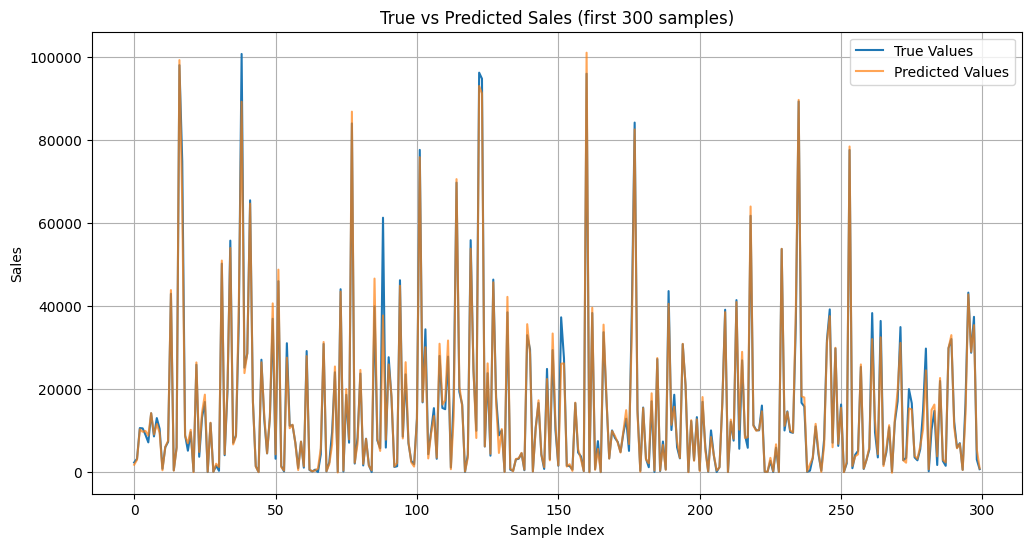

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual[:300], label='True Values')         
plt.plot(y_pred[:300], label='Predicted Values', alpha=0.7)
plt.title('True vs Predicted Sales (first 300 samples)')
plt.xlabel('Sample Index')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

### Performance Comparison across different models

In [ ]:
performance = pd.DataFrame({
    'Models' : ['Linear Regression', 'XGBoost','LGBM','Linear Regression with Scaled data',
                'XBGoost with Scaled Data','LGBM with Scaled Data','XGBoost Hyperparameter Tuned',
                'LBGM Hyperparameter Tuned','XGBoost Hyperparameter Tuned and Data Scaled',
                'LBGM Hyperparameter Tuned and Data Scaled'
                ],
    'Mean Squared Error': [37871290.84, 11324349.62,14459745.28,0,0,0,10539729.03,10717770.84,0,0],
    'R2 Score': [0.92616,0.97792,0.97180,0.92616,0.97767,0.97268,0.97945,0.97910,0.97914,0.97916]
})
performance

,Models,Mean Squared Error,R2 Score
0,Linear Regression,37871290.84,0.92616
1,XGBoost,11324349.62,0.97792
2,LGBM,14459745.28,0.97180
3,Linear Regression with Scaled data,0.00,0.92616
4,XBGoost with Scaled Data,0.00,0.97767
5,LGBM with Scaled Data,0.00,0.97268
6,XGBoost Hyperparameter Tuned,10539729.03,0.97945
7,LBGM Hyperparameter Tuned,10717770.84,0.97910
8,XGBoost Hyperparameter Tuned and Data Scaled,0.00,0.97914
9,LBGM Hyperparameter Tuned and Data Scaled,0.00,0.97916


### Finding the model with the best R2

In [ ]:
best_model = performance.loc[performance['R2 Score'].idxmax()]

print(f'Best Model: {best_model["Models"]}')
print(f'Best R2: {best_model["R2 Score"]}')
print(f'MSE: {best_model["Mean Squared Error"]}')

Best Model: XGBoost Hyperparameter Tuned
Best R2: 0.97945
MSE: 10539729.03
